In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold

In [2]:
data = pd.read_csv('AmesHousing.tsv',delimiter='\t')
print(data.shape)

(2930, 82)


In [3]:
print(len(str(data.shape)) *'-')
print(data.dtypes.value_counts())
data.head()

----------
object     43
int64      28
float64    11
dtype: int64


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [4]:
def transform_caracteristiques(dataFrame,ele_pourcentage):
    
    fig = plt.figure(figsize=(20,15))

    ax1 = fig.add_subplot(3,3,1)
    ax2 = fig.add_subplot(3,3,2)
    ax3 = fig.add_subplot(3,3,3)

    dataFrame.plot(x='Garage Area' ,y='SalePrice' ,ax=ax1 ,kind='scatter')
    dataFrame.plot(x='Gr Liv Area' ,y='SalePrice' ,ax=ax2 ,kind='scatter')
    dataFrame.plot(x='Overall Cond' ,y='SalePrice' ,ax=ax3 ,kind='scatter')

    plt.show()
    
    col = data.isnull().sum()
    colonne_a_supp = col[(col> len(col)*ele_pourcentage)].sort_values()
    dataFrame = dataFrame.drop(colonne_a_supp.index,axis=1)

    col_text = dataFrame.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
    colonne_text_a_supp = col_text[col_text>0]
    dataFrame = dataFrame.drop(colonne_text_a_supp.index,axis = 1) 

    col_numerique = dataFrame.select_dtypes(include=['float']).isnull().sum().sort_values()

    dataFrame = dataFrame.fillna(dataFrame.mean())

    annee_vente = dataFrame['Yr Sold']-dataFrame['Year Built']
    annee_vente[annee_vente < 0]
    annee_renovation = dataFrame['Yr Sold']-dataFrame['Year Remod/Add']
    annee_renovation[annee_renovation<0]
    dataFrame['annee_vente'] = annee_vente
    dataFrame['annee_renovation'] = annee_renovation
    dataFrame = dataFrame.drop([1702,2180,2181], axis=0)
    dataFrame = dataFrame.drop(['Yr Sold','Year Built','Year Remod/Add','Mo Sold','Sale Type','Sale Condition'],axis = 1)

    return dataFrame

def select_caracteristique(dataFrame,val_unique_caracteristique=1029 ,coeff_corr=0.3):
    data_num = dataFrame.select_dtypes(include=['int','float'])
    coef_corr_data = data_num.corr()['SalePrice'].abs().sort_values()
    
    coef_corr = coef_corr_data[coef_corr_data > coeff_corr]
    cor = dataFrame[coef_corr.index].corr() # .index pour le nombre de colonne
    sb.heatmap(cor)
    
    dataFrame = dataFrame.drop(coef_corr_data[coef_corr_data<coeff_corr].index, axis=1)
    caracteristique_categirique = ['MS Zoning','Street','Land Contour','Lot Config','Neighborhood','Condition 1','Condition 2','Bldg Type',
                                   'House Style','Roof Style','Roof Matl','Exterior 1st','Exterior 2nd','Foundation','Heating','Central Air',
                                    'SalePrice']
    
    trans_categorie_col = []
    for col in caracteristique_categirique:
        if col in dataFrame.columns:
            trans_categorie_col.append(col)
         
    #combien de valeur uniques dans chaque colonne catégorique
    val_unique_cat = dataFrame[trans_categorie_col].apply(lambda col: len(col.value_counts())).sort_values()   
    #limite arbitraire de 1029 valeurs unique 
    
    sup_non_val_unique = val_unique_cat[val_unique_cat > val_unique_caracteristique].index
    dataFrame = dataFrame.drop(sup_non_val_unique,axis=1)
    
    
    text_col = dataFrame.select_dtypes(include= ['object'])
    
    for col in text_col:
        dataFrame[col] = dataFrame[col].astype('category')
    dataFrame = pd.concat([dataFrame,pd.get_dummies(dataFrame.select_dtypes(include=['category']))],axis=1)

    return dataFrame

def train_and_test(dataFrame,k=0):
    
    
    numerique_data = dataFrame.select_dtypes(include= ['int','float'])
    caracteristique = numerique_data.columns.drop('SalePrice')
    
    lr = LinearRegression()
    
    if k ==0:
        train_data = dataFrame[:1460]
        test_data = dataFrame[1460:]  
        lr.fit(train_data[caracteristique],train_data["SalePrice"])
    
        predict = lr.predict(test_data[caracteristique])
        rmse = np.sqrt(mean_squared_error(test_data['SalePrice'],predict))
        return rmse
    
    if k == 1:
        shafeld_df = dataFrame.sample(frac=1, )
        train_data = dataFrame[:1460]
        test_data = dataFrame[1460:]
        
        lr.fit(train_data[caracteristique],train_data["SalePrice"])
        predict_one = lr.predict(test_data[caracteristique])
        rmse_one = np.sqrt(mean_squared_error(test_data['SalePrice'],predict_one))
        
        lr = LinearRegression()
        lr.fit(test_data[caracteristique],test_data["SalePrice"])
        predict_two = lr.predict(train_data[caracteristique])
        rmse_two = np.sqrt(mean_squared_error(train_data['SalePrice'],predict_two))
          
        rmse_moy = np.mean([rmse_one,rmse_two])
        return rmse_moy
    
    else: 
        kf = KFold(n_splits=k, shuffle=True)
        valeurs_rmse = []
        
        for train_index, test_index in kf.split(dataFrame):
            train = dataFrame.iloc[train_index]
            test = dataFrame.iloc[test_index]
            lr.fit(train[caracteristique],train["SalePrice"])
            prediction = lr.predict(test[caracteristique])
            rmse = np.sqrt(mean_squared_error(test['SalePrice'],prediction))
            valeurs_rmse.append(rmse)
        avg_rmse = np.mean(valeurs_rmse)
        return avg_rmse
        

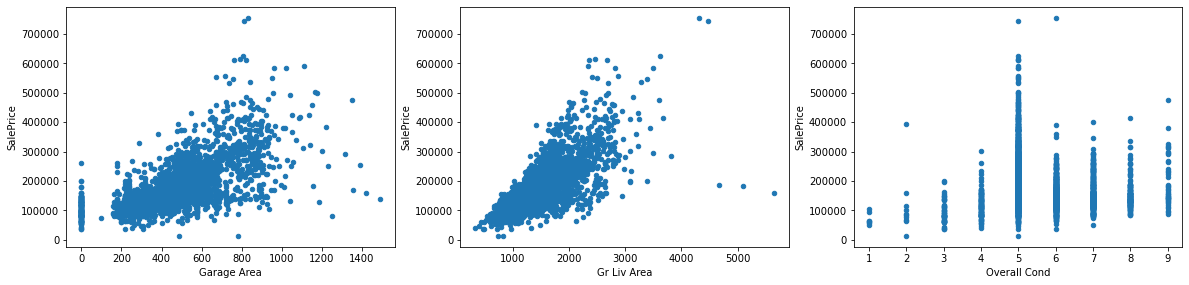

In [5]:
transform_df = transform_caracteristiques(data,0.05)


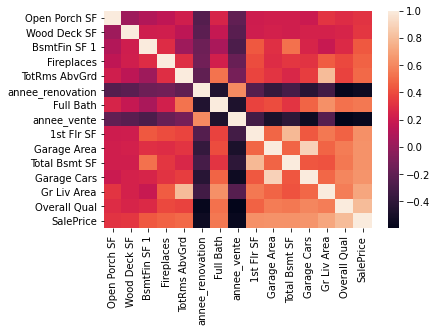

In [6]:
select_df = select_caracteristique(transform_df)

Text(0, 0.5, 'RMSE')

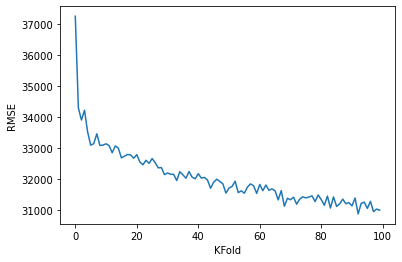

In [7]:
res = []

for i in range (100) :
    rmse_df = train_and_test(select_df,k=i)
    res.append(rmse_df)
x = [i for i in range(100)]
y = res
plt.plot(x,y)
plt.xlabel('KFold')
plt.ylabel('RMSE')